<a href="https://colab.research.google.com/github/mahalaxmy/ADL/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.0
    mask -= 1
    return image, mask


In [ ]:
def load_image_train(data):
    image = tf.image.resize(data['image'], (128, 128))
    mask = tf.image.resize(data['segmentation_mask'], (128, 128))
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    return normalize(image, mask)

In [ ]:
def load_image_test(data):
    image = tf.image.resize(data['image'], (128, 128))
    mask = tf.image.resize(data['segmentation_mask'], (128, 128))
    return normalize(image, mask)


In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
# Display function
def display(display_list):
    plt.figure(figsize=(7, 7))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

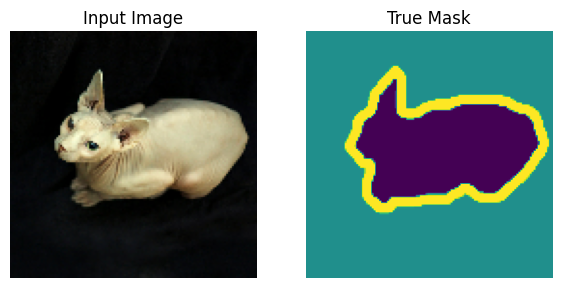

In [ ]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [ ]:
def unet_model():
    inputs = tf.keras.layers.Input((128, 128, 3))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(s)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    u4 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(p3)
    u4 = tf.keras.layers.concatenate([u4, c3])
    c4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u4)

    u5 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = tf.keras.layers.concatenate([u5, c2])
    c5 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u5)

    u6 = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c1])
    c6 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u6)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c6)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = unet_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda_3 (Lambda)           (None, 128, 128, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv2d_13 (Conv2D)          (None, 128, 128, 16)         448       ['lambda_3[0][0]']            
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 16)           0         ['conv2d_13[0][0]']           
 g2D)                                                                                       

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
EPOCHS = 15

# Take smaller subsets for demonstration purposes
train_dataset_demo = train.take(30).batch(10).repeat(EPOCHS)
test_dataset_demo = test.take(10).batch(2)

In [ ]:
history = model.fit(train_dataset_demo,
                    epochs=EPOCHS,
                    steps_per_epoch=len(list(train_dataset_demo)) // EPOCHS,
                    validation_data=test_dataset_demo)

Epoch 1/15
3/3 [==============================] - 5s 855ms/step - loss: 0.6923 - accuracy: 0.5054 - val_loss: 0.6903 - val_accuracy: 0.6271
Epoch 2/15
3/3 [==============================] - 2s 644ms/step - loss: 0.6894 - accuracy: 0.5848 - val_loss: 0.6868 - val_accuracy: 0.6271
Epoch 3/15
3/3 [==============================] - 2s 688ms/step - loss: 0.6859 - accuracy: 0.5848 - val_loss: 0.6824 - val_accuracy: 0.6271
Epoch 4/15
3/3 [==============================] - 3s 1s/step - loss: 0.6814 - accuracy: 0.5848 - val_loss: 0.6762 - val_accuracy: 0.6271
Epoch 5/15
3/3 [==============================] - 3s 802ms/step - loss: 0.6748 - accuracy: 0.5848 - val_loss: 0.6663 - val_accuracy: 0.6271
Epoch 6/15
3/3 [==============================] - 2s 728ms/step - loss: 0.6635 - accuracy: 0.5848 - val_loss: 0.6480 - val_accuracy: 0.6271
Epoch 7/15
3/3 [==============================] - 2s 708ms/step - loss: 0.6419 - accuracy: 0.5848 - val_loss: 0.6108 - val_accuracy: 0.6271
Epoch 8/15
3/3 [=======